In [1]:
from keras.engine import  Model
from keras.layers import Input
from keras_vggface.vggface import VGGFace

# Convolution Features
vgg_features = VGGFace(model="resnet50", include_top=False, input_shape=(224, 224, 3), pooling='avg')

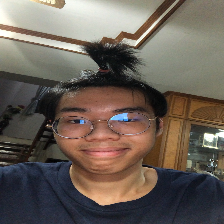

(224, 224, 3)
(1, 224, 224, 3)
inferenced time 25.93231987953186
[[0. 0. 0. ... 0. 0. 0.]]


In [2]:
import cv2
import numpy as np
from PIL import Image
import time
im_path = "sample_image/earth_regis.jpg"
img = cv2.imread(im_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(224,224))

#debug
img_debug = Image.fromarray(img)
display(img_debug)

print(img.shape)
img=np.array((img,))
print(img.shape)

start = time.time()
feature = vgg_features.predict(img)
print(f"inferenced time {time.time() - start}")

print(feature)

In [3]:
faceCascade = cv2.CascadeClassifier('Cascades/haarcascade_frontalface_default.xml')

def detect_face(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.2,
        minNeighbors=5,
        minSize=(20, 20)
    )
    cropped_face = np.zeros(img.shape)
    (x0, y0, w0, h0) = (0,0,0,0)
    if len(faces)!=0:
        print(f"{len(faces)} face detected")
        for (x, y, w, h) in faces:
            cropped_face = img[y:y + h, x:x + w]
            (x0, y0, w0, h0) = (x, y, w, h)
    else:
        print("face not detected!")
    return cropped_face, (x0, y0, w0, h0)

# def draw_face(img):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     faces = faceCascade.detectMultiScale(
#         gray,
#         scaleFactor=1.2,
#         minNeighbors=5,
#         minSize=(20, 20)
#     )
#     cropped_face = np.zeros(img.shape)
#     (x0, y0, w0, h0) = (0,0,0,0)
    
#     if len(faces)!=0:
#         for (x, y, w, h) in faces:
#             cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
#             (x0, y0, w0, h0) = (x, y, w, h)
#     return img, (x0, y0, w0, h0)

1 face detected


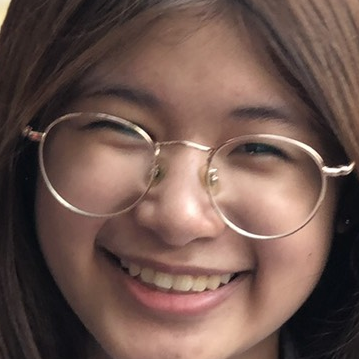

In [5]:
im_path = "sample_image/dene_regis.jpg"
img = cv2.imread(im_path)
result,_ = detect_face(img)
#debug
img = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
img_debug = Image.fromarray(img)
display(img_debug)
        

create registration image

In [6]:
def preprocess(img_path, is_cropped = False):
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if not is_cropped:
        face ,_ = detect_face(img)
    else:
        face = img
    face = cv2.resize(face,(224,224))
    face=np.array((face,))
    return face

def preprocess_video(img):
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    face, (x, y, w, h) = detect_face(img)
    face = cv2.resize(face,(224,224))
    face=np.array((face,))
    return face, (x, y, w, h)

In [7]:
import os
from tqdm import tqdm
img_list = [f for f in os.listdir("sample_image") if "regis" in f]
# print(regis_list)

regis_data = {}
for img_name in tqdm(img_list):
    img_path = os.path.join("sample_image",img_name)
    img = preprocess(img_path)
    #extract feature
    feature = vgg_features.predict(img)
    #person name
    person_name = img_name.split("_")[0]
    regis_data[person_name] = feature

  0%|          | 0/5 [00:00<?, ?it/s]

1 face detected


 20%|██        | 1/5 [00:04<00:16,  4.04s/it]

1 face detected


 40%|████      | 2/5 [00:05<00:08,  2.69s/it]

1 face detected


 60%|██████    | 3/5 [00:06<00:03,  1.89s/it]

1 face detected


 80%|████████  | 4/5 [00:07<00:01,  1.39s/it]

1 face detected


100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


In [8]:
sorted(list(regis_data.keys()))

['dene', 'earth', 'nish', 'pan', 'patter']

inference test

In [9]:
regis_person = sorted(list(regis_data.keys()))
extracted_feat = []
for person in regis_person:
    extracted_feat.append(regis_data[person])

1 face detected
preprocess time : 0.39863038063049316


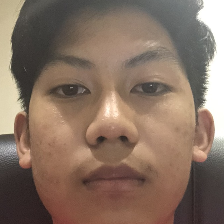

inference time : 0.4426703453063965
postprocess time : 0.06927180290222168


In [10]:
input_path = "sample_image/pan_infer.jpg"

#preprocess
start_pre = time.time()
img_infer = preprocess(input_path,False)
print(f"preprocess time : {time.time() - start_pre}")

#debug
img_debug = Image.fromarray(img_infer.astype(np.uint8).reshape(224,224,3))
display(img_debug)

#inference
start_infer = time.time()
feature_infer = vgg_features.predict(img_infer)
print(f"inference time : {time.time() - start_infer}")

#postprocess
start_pos = time.time()
extracted_feat = np.asarray(extracted_feat)
distances = [np.linalg.norm(f) for f in extracted_feat-feature_infer]
print(f"postprocess time : {time.time() - start_pos}")

In [11]:
print(regis_person[np.argmin(distances)])
#debug
print(regis_person)
print(distances)

pan
['dene', 'earth', 'nish', 'pan', 'patter']
[134.89552, 119.73252, 119.12103, 58.312904, 127.292175]


Video inference

In [12]:
input_path = "sample_image/earth1_trim.mp4"

cap = cv2.VideoCapture(input_path)
_,frame = cap.read()
input_size = (frame.shape[1], frame.shape[0])
input_size = (480,270)

#record inference result
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
save_path = "output/out4.mp4"
writer = cv2.VideoWriter(save_path, fourcc, 2, input_size)

fps = 0.0

while True:
    ret, frame = cap.read()
    start = time.time()
    if ret:
        #preprocess
        start_pre = time.time()
        frame = cv2.resize(frame, input_size)
        img_infer, (x, y, w, h) = preprocess_video(frame)
        print(f"preprocess time : {time.time() - start_pre}")
        
        #inference
        start_infer = time.time()
        feature_infer = vgg_features.predict(img_infer)
        print(f"inference time : {time.time() - start_infer}")

        #postprocess
        start_pos = time.time()
        extracted_feat = np.asarray(extracted_feat)
        distances = [np.linalg.norm(f) for f in extracted_feat-feature_infer]
        print(f"postprocess time : {time.time() - start_pos}")
        
        #result
        person_name = regis_person[np.argmin(distances)]
        
        #calculate fps
        end = time.time()
        fps = 1/(end -start)
        print("fps {:.2f}".format(fps))
        
        #display result
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, person_name, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        cv2.putText(frame, "fps {:.2f}".format(fps), (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        writer.write(frame)
        
        #debug
#         frame = Image.fromarray(frame.astype(np.uint8))
#         display(frame)
        

    else:
        writer.release()
        cap.release()
        print(f"result saved to {save_path}")
        break

1 face detected
preprocess time : 0.09196925163269043
inference time : 0.44620823860168457
postprocess time : 0.0024003982543945312
fps 1.83
1 face detected
preprocess time : 0.05877494812011719
inference time : 0.3405117988586426
postprocess time : 0.003450632095336914
fps 2.45
1 face detected
preprocess time : 0.05380511283874512
inference time : 0.32087039947509766
postprocess time : 0.0022690296173095703
fps 2.62
1 face detected
preprocess time : 0.06563496589660645
inference time : 0.32224535942077637
postprocess time : 0.0016853809356689453
fps 2.56
1 face detected
preprocess time : 0.06483769416809082
inference time : 0.3424558639526367
postprocess time : 0.0016808509826660156
fps 2.44
1 face detected
preprocess time : 0.07210397720336914
inference time : 0.32390260696411133
postprocess time : 0.001575469970703125
fps 2.48
1 face detected
preprocess time : 0.06169915199279785
inference time : 0.3255472183227539
postprocess time : 0.0015633106231689453
fps 2.54
1 face detected
pr

In [ ]:
input_path = "sample_image/earth1_trim.mp4"

cap = cv2.VideoCapture(input_path)

#changing w, h of webcam
# cap.set(3, 640)  # set Width
# cap.set(4, 480)  # set Height
# print(cap.get(3), cap.get(4))

_,frame = cap.read()
input_size = (frame.shape[1], frame.shape[0])
#manual input size
input_size = (480,270)
print(input_size)

#record inference result
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
save_path = "output/out6.mp4"
writer = cv2.VideoWriter(save_path, fourcc, 20, input_size)

print(f"fps input : {cap.get(cv2.CAP_PROP_FPS)}")
fps = 0.0
start = time.time()
while True:
    
    ret, frame = cap.read()
    if ret:
        #changing w, h of input video
        frame = cv2.resize(frame , input_size)
        #preprocess
        start_pre = time.time()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = faceCascade.detectMultiScale(
            gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(20, 20)
        )
        (x0, y0, w0, h0) = (0,0,0,0)
        if len(faces)!=0:
            print(f"{len(faces)} face detected")
            for (x, y, w, h) in faces:
#                 cropped_face = img[y:y + h, x:x + w]
                (x0, y0, w0, h0) = (x, y, w, h)
        print(f"preprocess time : {time.time() - start_pre}")
        
        #calculate fps
        end = time.time()
        fps = 1.0/(end -start)
        print(fps)
        start = end
        
        #display result
        cv2.rectangle(frame, (x0, y0), (x0 + w0, y0 + h0), (0, 255, 0), 2)
#         cv2.putText(frame, person_name, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        cv2.putText(frame, "fps {:.2f}".format(fps), (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        writer.write(frame)
        
        #debug
#         frame = Image.fromarray(frame.astype(np.uint8))
#         display(frame)
        

    else:
        writer.release()
        cap.release()
        print(f"result saved to {save_path}")
        break